# Training of the DistilBERT Text Classifier

### What is BERT??

- BERT stands for Biidirectional Encoder Representaion from Transformers
- It is based on the enocder part of transformer.
- It is trained on Masked language modeling. \
   This stone is very ______. I can not lift it. BERT will predict this ---- with some word like **heavy**.
- Also trained on next sentence prediction.
  My friend Ujwal is good. Prediction- He is very soft spoken.

In this notebook we are going to train a **DistilBERT** transformer for the text classification on the dataset of **emotion** detection. Firstly, we will require to download and pre-process the dataset.

![Architecture of DistilBERT text classifier](https://miro.medium.com/v2/resize:fit:1358/1*GUd19qrm7YxnhE0ZQJybVw.png)

## Loading of the dataset

For our usecase we are going to use the the **emotion** dataset from the **huggingface**.\
Let's firstly login into <code>huggingface_hub</code>

In [ ]:
from huggingface_hub import login
#login(token="Paste your logging in token") #Logging in token

Let's look at the datasets that are available on the <code>huggingface_hub</code>.

In [ ]:
from huggingface_hub import list_datasets
#all_datasets = list(list_datasets(token="Paste your logging in token"))
print(f"There are {len(all_datasets)} datasets currently present on the hub")
dataset_names = [dataset.id for dataset in all_datasets[:10]]


There are 515452 datasets currently present on the hub


Let's load the <code>emotion</code> dataset.

In [4]:
from datasets import load_dataset    # Importing the dataset class from the dataset library
emotions = load_dataset("emotion")   # Creating the emotions variable to store our dataset
emotions   #Displaying the dataset

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

split/train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

split/validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

split/test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

As it is visible the dataset its pre-processed into **train**,**validation** and **test**. Let's make a dataset from each one of them.

In [5]:
train_ds=emotions["train"]  # accessing the training part of the dataset
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [6]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [7]:
val_ds=emotions['validation']
val_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 2000
})

In [8]:
test_ds=emotions['validation']
test_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 2000
})

Let's look at the first row of <code>train_ds</code> to see how is data available.

In [9]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

So we have a <code>text</code> and a corresponding <code>label</code>. This label probably maps towards a particular sentitment. Let's look at the first 10 rows.

In [10]:
train_ds[0:10]

{'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong',
  'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
  'i am feeling grouchy',
  'ive been feeling a little burdened lately wasnt sure why that was',
  'ive been taking or milligrams or times recommended amount and ive fallen asleep a lot faster but i also feel like so funny',
  'i feel as confused about life as a teenager or as jaded as a year old man',
  'i have been with petronas for years i feel that petronas has performed well and made a huge profit',
  'i feel romantic too'],
 'label': [0, 0, 3, 2, 3, 0, 5, 4, 1, 2]}

In [11]:
print(train_ds.features)

{'text': Value('string'), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'])}


Let's convert this dataset into a dataframe.

In [12]:
import pandas as pd #importing the pandas library

emotions.set_format(type="pandas")    #Setting up the emotions to pandas format so that whenever the split takes place it is in the dataframe format
df=emotions["train"][:] # Setting the dataframe to the train split of the emotions
df.head()   # Looking at the first 5 rows

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


Look's good but for out training purpose we will need that the text should be mapped to the emotion not the label corresponding to that emotion. So let's do that.

In [13]:
def label_int2str(row):   #Defining a custom function to iterate over each row and map its label code to the label name.
  return emotions["train"].features["label"].int2str(row)

df["label_name"]=df['label'].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


Looks good.

## Looking at the class distribution

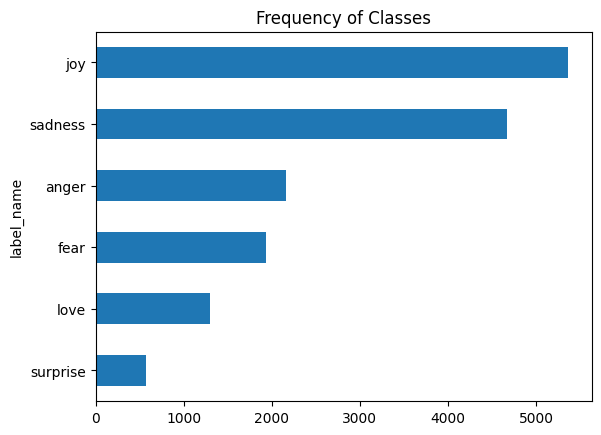

In [14]:
import matplotlib.pyplot as plt
df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

The dataset seems very unbalanced.

## Tokenization

Let's tokenize the dataset.\
For that let's firstly load the pre-trained tokenizer of the **DistilBERT**

In [15]:
from transformers import AutoTokenizer # Impoirting the AutoTokenizer class from transformers
model_ckpt = "distilbert-base-uncased" # Loading the model specific checkpoints.
tokenizer = AutoTokenizer.from_pretrained(model_ckpt) #using the specifiect tokenizer with assocciated model.

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Let's just see how the tokenizer is tokenizing the the a text "Let's do tokenizatio in NLP. Transformers are great!".

In [16]:
text="Let's do tokenization in NLP. Transformers are great!"

In [17]:
encoded_text=tokenizer(text)  #Tokenizing the text
encoded_text # Looking at the encoded tokenized text

{'input_ids': [101, 2292, 1005, 1055, 2079, 19204, 3989, 1999, 17953, 2361, 1012, 19081, 2024, 2307, 999, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

Now each of the above encoding id is mapped to a token. Let's convert each of the id s to a token.

In [18]:
tokens=tokenizer.convert_ids_to_tokens(encoded_text.input_ids) # The id s are being shown as the tokens they are pointing to
tokens

['[CLS]',
 'let',
 "'",
 's',
 'do',
 'token',
 '##ization',
 'in',
 'nl',
 '##p',
 '.',
 'transformers',
 'are',
 'great',
 '!',
 '[SEP]']

We can use another function of the <code>tokenizer</code> to convert them back to the string.

In [19]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] let ' s do tokenization in nlp. transformers are great! [SEP]


Let's look at some other attributes of <code>tokenizer</code>

In [20]:
print(tokenizer.vocab_size) # Inspecting the vocabulary size
print(tokenizer.model_max_length)  # Models maximum context size
print(tokenizer.model_input_names) # Names of the fields

30522
512
['input_ids', 'attention_mask']


## Tokenizing The Whole Dataset

The <code>DistilBERT</code> can not work with the whole lines of text input in each row. So it's important to tokenize each of the row of the dataset.

In [21]:
def tokenize(batch):   # A custom function which can tokenize each row of the given batch of the rows (basically dataset).
  return tokenizer(batch['text'],padding=True, truncation=True)

The above custom function has been defined so that dataset like emotion can be tokenized on each of the train, validation and test dataset of it. \
Let's do it with the sample of dataset of <code>emotions</code>.

In [22]:
# We need to reset the format to default.
emotions.reset_format()   # Reseting the format of the dataset from the pandas to the default so that it can be mapped properly
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None) # Creating the encoding of the whole dataset
emotions_encoded

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

Let's see how the encoding has been done.

In [23]:
encoding_train_df=emotions_encoded['train'].to_pandas()[['text','label','input_ids','attention_mask']].head() # Accessing the encoding done on the training part of the dataset.
encoding_train_df

,text,label,input_ids,attention_mask
0,i didnt feel humiliated,0,"[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0...","[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,i can go from feeling so hopeless to so damned...,0,"[101, 1045, 2064, 2175, 2013, 3110, 2061, 2062...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,im grabbing a minute to post i feel greedy wrong,3,"[101, 10047, 9775, 1037, 3371, 2000, 2695, 104...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ..."
3,i am ever feeling nostalgic about the fireplac...,2,"[101, 1045, 2572, 2412, 3110, 16839, 9080, 128...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,i am feeling grouchy,3,"[101, 1045, 2572, 3110, 24665, 7140, 11714, 10...","[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ..."


In [24]:
encoding_train_df[['input_ids','attention_mask']]

,input_ids,attention_mask
0,"[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0...","[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[101, 1045, 2064, 2175, 2013, 3110, 2061, 2062...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,"[101, 10047, 9775, 1037, 3371, 2000, 2695, 104...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ..."
3,"[101, 1045, 2572, 2412, 3110, 16839, 9080, 128...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,"[101, 1045, 2572, 3110, 24665, 7140, 11714, 10...","[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ..."


## Training a text classifier

Now since we have successfully tokenized the dataset to use as input in our DistilBERT we are going to train the text classifier. In this use case we have two methods to train our classifier-
- Feature based extraction
- Fine tuning

**Feature Based Extraction** - We use the hidden states as features and just train a classifier on them, without
 modifying the pretrained model.

 **Fine-tuning** -  We train the whole model end-to-end, which also updates the parameters of the
 pretrained model.

## Transformer as feature extractors

### Using Pretrained Features

Let's use the pre-trained weights of the model and by using an auto class from **huggingface Transformers** namely <code>AutoModel</code> using <code>.pretrained()</code>.

PyTorch works with arrays and it is very important for the arrays to be on the same device. For example for array A + B = C performation A and B need to be both on GPU or on the same CPU.

In [25]:
import torch    # Importing the PyTorch library
print(torch.__version__)  # Checking the version
from transformers import AutoModel    # Importing AutoModel
model_ckpt = "distilbert-base-uncased" # Loading the model specific checkpoints.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Device agnostic code - Model will use GPU if it is available otherwise it will run on CPU.
model = AutoModel.from_pretrained(model_ckpt).to(device) # Setting up the model

2.8.0+cu126


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

### Extracting the last hidden state

Firstly for a demo text let's extract the hidden state to get more familiar with it.

In [26]:
text_01= "This is some text" # Example first text
text_02="This is some another text which is longer  in length" # Example 2nd text.
texts=[text_01, text_02] # Being put in a list.
inputs=tokenizer(texts, return_tensors="pt",padding=True, truncation=True)   # each of the text is being converted into tokens
print(f"Input tensor shape: {inputs['input_ids'].size()}")
inputs

Input tensor shape: torch.Size([2, 12])


{'input_ids': tensor([[ 101, 2023, 2003, 2070, 3793,  102,    0,    0,    0,    0,    0,    0],
        [ 101, 2023, 2003, 2070, 2178, 3793, 2029, 2003, 2936, 1999, 3091,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

Looking at the output above we can see that the shape of the tensor we are getting is <code>[batch_size , n_tokens]</code>. Please observe that the first text that is <code>text_01</code> has 6 tokens only but rest 6 are being added as padding. \
Let's pass these texts through the model and get the hidden state.

In [27]:
inputs = {k:v.to(device) for k,v in inputs.items()} # Storing each of the tensors into the device defined earlier.
with torch.no_grad():   # This will avoid the gradient calculation.
 outputs = model(**inputs) #Last hidden state
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.2319, -0.1292,  0.0700,  ..., -0.0878,  0.2507,  0.4916],
         [-0.6010, -0.2739, -0.1575,  ..., -0.3209,  0.4852,  0.3530],
         [-0.2209, -0.2036,  0.1491,  ..., -0.0331,  0.0851,  1.1578],
         ...,
         [-0.1628, -0.0808, -0.1666,  ...,  0.2572,  0.0669,  0.3628],
         [-0.1950, -0.0549, -0.1615,  ...,  0.2631,  0.0706,  0.4010],
         [-0.2876,  0.0337, -0.0987,  ...,  0.1651,  0.0406,  0.3784]],

        [[-0.2512, -0.1831, -0.1812,  ...,  0.1035,  0.3510,  0.4942],
         [-0.5048, -0.1990, -0.5123,  ..., -0.0859,  0.6640,  0.1480],
         [-0.4195, -0.0555, -0.2084,  ...,  0.1118,  0.2241,  0.9175],
         ...,
         [-0.9375, -0.6446, -0.1826,  ..., -0.1423,  0.1260,  0.6865],
         [-0.1127, -0.4029,  0.1243,  ...,  0.4615,  0.3959,  0.3768],
         [ 0.8966,  0.0059, -0.3954,  ..., -0.0042, -0.5418, -0.2876]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [29]:
outputs.last_hidden_state.size()

torch.Size([2, 12, 768])

So the shape of the outputs of the last hidden state is given above as <code>[batch_size , n_tokens , hidden_dim]</code>

Now, let's extract the last hidden state for the whole training dataset.

Let's define a custom function to extract the last hidden state from the each input of the whole dataset.

In [30]:
emotions_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [33]:
def extract_hidden_states(batch): # Defining the custom function
 # Place model inputs on the GPU or the CPU if the GPU is not available
 inputs = {k:v.to(device) for k,v in batch.items()
          if k in tokenizer.model_input_names}     # Setting the device for all the inputs
 # Extract last hidden states
 with torch.no_grad():   # Turning of the gradient calculation for inferences
  last_hidden_state = model(**inputs).last_hidden_state    # Getting the last hidden state
 # Return vector for [CLS] token
 return {"hidden_state": last_hidden_state[:,0].cpu().numpy()} # Setting up the returned tensors to the CPU so that it can be converted into numpy arrays.

Previously, we have calculated the <code>emotions_encoded</code>. We need to pass it to the function above.

In [34]:
emotions_encoded["train"]

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 16000
})

In [35]:
emotions_encoded.set_format("torch",columns=["input_ids", "attention_mask", "label"]) # Setting format for the emotions_encoded to torch since the function expects the inputs to be tensors

emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Now in the cell above <code>emotions_hidden</code> we have gotten all the <code>last_hidden_states</code> for the training dataset of the emotions.

In [36]:
 emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

### Creating a feature matrix

Now since we have gotten the last hidden states then we have all the pre-requisites to train our classifier using these features.\
So let's create a feature matrix

In [38]:
import numpy as np
X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

Let's train a simple classifier using logistic regression. To train using the train dataset and score it using the validation dataset.

In [39]:
from sklearn.linear_model import LogisticRegression # Importing the LogisticRegression class from the sklearn.linear_model

# We increase `max_iter` to guarantee convergence

lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)  # Training the model on X_train, y_train
lr_clf.score(X_valid, y_valid)  # Evaluating the model on X_valid, y_valid


0.6345

63 percent is a fine classification let's use <code>sklearn.dummy.DummyClassifier</code> to get the score of a dumb classifier on our multilabeled dataset

In [40]:
from sklearn.dummy import DummyClassifier # DummyClassifier stands for a dumb classifier like giving same label for all the inputs or doing some random output labeling on all the input irrespoective of the input
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

So a 35 percent accuracy is given by a dumb model which seems reasonable when you are given with multilabeled unbalanced data.

Let's plot a confusion matrix to get to know better what are the correct and incorrect classification of out Logisitic Regression trained model fitted on the validation of dataset of the emotion dataset.

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']


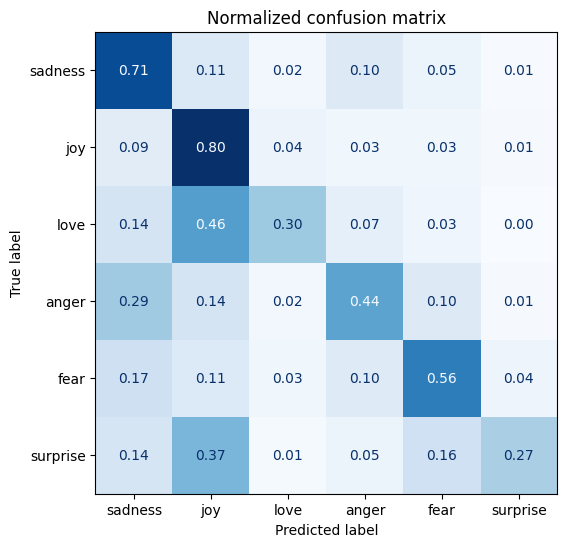

In [41]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix # Importing the confusion matrix class

def plot_confusion_matrix(y_preds, y_true, labels):  # creating a custom function for the confusion matrix given the predicted y and the actual y that it should have predicted
 cm = confusion_matrix(y_true, y_preds, normalize="true")
 fig, ax = plt.subplots(figsize=(6, 6))
 disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
 disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
 plt.title("Normalized confusion matrix")
 plt.show()
y_preds = lr_clf.predict(X_valid)
labels = emotions["train"].features["label"].names
print(labels)
plot_confusion_matrix(y_preds, y_valid, labels)

## Fine-Tuning Transformers

Unlike last time we are going to train all the parameters of the model and will train them. Some key changes in the work this time will be-:
- We will be using <code>AutoModelForSequenceClassification</code> in place of <code>LogisticRegression</code> because unlike the default architecture of **DistilBERT** it has a classifier header at top so we need not to append one ourself.
- We will be defining the batch size, learning rate etc things while training and will use the <code>TrainingArguments</code> which makes it easy to setup and get the weights into output directory to save and reuse later.

In [42]:
from transformers import AutoModelForSequenceClassification  # Importing the AutoModelForSequenceClassification class from transformers library
num_labels = 6   # Number of output labels being defined to throws as input in the model
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Let's define a custom function to compute the accuracy.

In [43]:
from sklearn.metrics import accuracy_score, f1_score   # Importing the accuracy_score and the f1_score from the sklearn.metrics
def compute_metrics(pred):   # Defining a custom function for computing the accuracy metrics
 labels = pred.label_ids
 preds = pred.predictions.argmax(-1)
 f1 = f1_score(labels, preds, average="weighted")
 acc = accuracy_score(labels, preds)
 return {"accuracy": acc, "f1": f1}

### Training the model

We will be using the <code>Trainer</code> and <code>TrainingArguments</code> class. Usually we need to define the custom function for the training and testing when we are using a model but <code>transformers</code> library gives us the leverage that we need not to do that work. Also, the best part it about saving the weights which also need a custom function but in the <code>TrainingArguments</code> we can just specifiy the <code>output_dir</code> to do that work.

In [44]:
from transformers import Trainer, TrainingArguments                     # Importing the Trainer and TrainingArguments
batch_size = 64                                                         # Defining the value of batch-size.
logging_steps = len(emotions_encoded["train"]) // batch_size            # Defining the logging step
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
 num_train_epochs=2,
 learning_rate=2e-5,
 per_device_train_batch_size=batch_size,
 per_device_eval_batch_size=batch_size,
 weight_decay=0.01,
 eval_strategy="epoch",
 disable_tqdm=False,
 logging_steps=logging_steps,
 push_to_hub=False,
 log_level="error")

After setting up all the arguments let finally train our **DistilBERT** and do the the validation on the validation set.

In [45]:
from transformers import Trainer   # Importing the Trainer
trainer = Trainer(model=model, args=training_args,
 compute_metrics=compute_metrics,
 train_dataset=emotions_encoded["train"],
 eval_dataset=emotions_encoded["validation"],
 tokenizer=tokenizer)
trainer.train();

/tmp/ipython-input-3136879451.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: s4g4r (s4g4r-iiser-berhampur) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.795400,0.301646,0.916000,0.915299
2,0.246400,0.218276,0.922500,0.922395


Let's look more in the output of the validation predictions.

In [47]:
preds_output = trainer.predict(emotions_encoded["test"])
preds_output.metrics


{'test_loss': 0.22049258649349213,
 'test_accuracy': 0.915,
 'test_f1': 0.9144909302469039,
 'test_runtime': 4.1487,
 'test_samples_per_second': 482.075,
 'test_steps_per_second': 7.713}

Let's get the <code>y_preds</code> that is the predictions and plot a confusion matrix again.

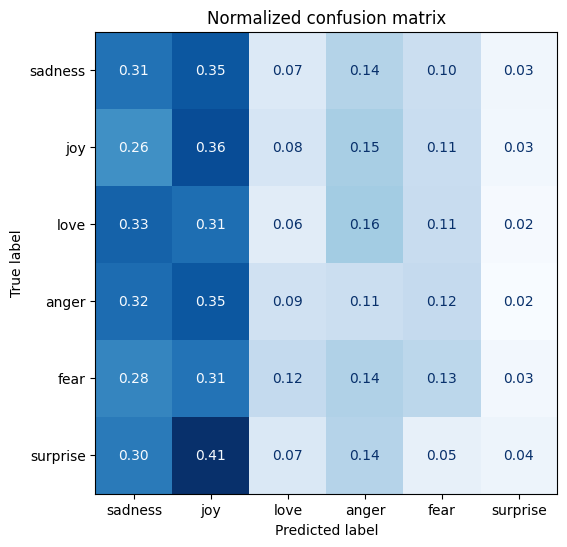

In [48]:
y_preds = np.argmax(preds_output.predictions, axis=1)
plot_confusion_matrix(y_preds, y_valid, labels)


## Saving and sharing the model

Let's save this model for the future use.

In [49]:
 #trainer.push_to_hub(commit_message="Training completed!")

In [50]:
from transformers import pipeline
import pandas as pd

model_id = "S-4-G-4-R/distilbert-base-uncased-finetuned-emotion"
classifier = pipeline("text-classification", model=model_id)

config.json:   0%|          | 0.00/831 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [51]:
custom_tweet = "Hii today I am very happy because I had a good exam"
preds = classifier(custom_tweet, return_all_scores=True)
preds

/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


[[{'label': 'LABEL_0', 'score': 0.007877050898969173},
  {'label': 'LABEL_1', 'score': 0.9757803678512573},
  {'label': 'LABEL_2', 'score': 0.008335910737514496},
  {'label': 'LABEL_3', 'score': 0.0036863423883914948},
  {'label': 'LABEL_4', 'score': 0.00252139032818377},
  {'label': 'LABEL_5', 'score': 0.0017989740008488297}]]

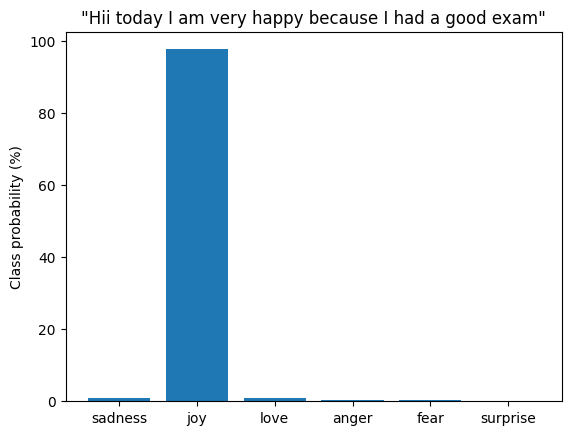

In [52]:
 import matplotlib.pyplot as plt
 preds_df = pd.DataFrame(preds[0])
 plt.bar(labels, 100 * preds_df["score"], color='C0')
 plt.title(f'"{custom_tweet}"')
 plt.ylabel("Class probability (%)")
 plt.show()